# Defining Good Food

# Project Summary

We often ask ourselves what is right and what is wrong when it comes to eating. In this project, we will analyze food data to answer some of the following questions/guideline:
1. Which fruit provides the most vitamin C? What are other good sources of this nutrient?
2. How are the calorie content and water content of a food item related?
3. What are the possible disadvantages of a no-carb diet? What potential health issues might arise from consuming too much protein?
4. Since a gram of fat offers approximately 9 kilocalories and both protein and carbohydrates provide 4 kilocalories per gram, I intend to create a linear model to see if the data supports these values.
5. Examine the errors in my linear model to uncover any hidden calorie sources in foods.

## The data

I have gathered nutrition data from USDA's FoodData Central [website](https://fdc.nal.usda.gov/download-datasets.html). 

This dataset includes the calorie content and nutritional breakdown of 7,793 commonly consumed foods. Each row corresponds to a specific food item, with nutritional values standardized for a 100g serving. Below is an explanation of the columns:

- **FDC_ID**: A unique identifier for each food item in the database.
- **Item**: The name or description of the food product.
- **Category**: The category or classification of the food item, such as "Baked Products" or "Vegetables and Vegetable Products".
- **Calories**: The energy content of the food, presented in kilocalories (kcal).
- **Protein**: The protein content of the food, measured in grams.
- **Carbohydrate**: The carbohydrate content of the food, measured in grams.
- **Total fat**: The total fat content of the food, measured in grams.
- **Cholesterol**: The cholesterol content of the food, measured in milligrams.
- **Fiber**: The dietary fiber content of the food, measured in grams.
- **Water**: The water content of the food, measured in grams.
- **Alcohol**: The alcohol content of the food (if any), measured in grams.
- **Vitamin C**: The Vitamin C content of the food, measured in milligrams.

In [1]:
import pandas as pd
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

df_food = pd.read_csv('nutrition.csv')
df_food

,FDC_ID,Item,Category,Calories,Protein,Carbohydrate,Total fat,Cholesterol,Fiber,Water,Alcohol,Vitamin C
0,167512,"Pillsbury Golden Layer Buttermilk Biscuits, Ar...",Baked Products,307.0 kcal,5.88 g,41.18 g,13.24 g,0.0 mg,1.2 g,35.5 g,NaN,NaN
1,167513,"Pillsbury, Cinnamon Rolls with Icing, refriger...",Baked Products,330.0 kcal,4.34 g,53.42 g,11.27 g,0.0 mg,1.4 g,27.86 g,NaN,0.1 mg
2,167514,"Kraft Foods, Shake N Bake Original Recipe, Coa...",Baked Products,377.0 kcal,6.1 g,79.8 g,3.7 g,NaN,NaN,3.2 g,NaN,NaN
3,167515,"George Weston Bakeries, Thomas English Muffins",Baked Products,232.0 kcal,8.0 g,46.0 g,1.8 g,NaN,NaN,42.6 g,NaN,NaN
4,167516,"Waffles, buttermilk, frozen, ready-to-heat",Baked Products,273.0 kcal,6.58 g,41.05 g,9.22 g,15.0 mg,2.2 g,40.34 g,0.0 g,0.0 mg
...,...,...,...,...,...,...,...,...,...,...,...,...
7788,175300,"Game meat, buffalo, water, cooked, roasted","Lamb, Veal, and Game Products",131.0 kcal,26.83 g,0.0 g,1.8 g,61.0 mg,0.0 g,68.81 g,NaN,0.0 mg
7789,175301,"Game meat, elk, raw","Lamb, Veal, and Game Products",111.0 kcal,22.95 g,0.0 g,1.45 g,55.0 mg,0.0 g,74.38 g,NaN,0.0 mg
7790,175302,"Game meat, elk, cooked, roasted","Lamb, Veal, and Game Products",146.0 kcal,30.19 g,0.0 g,1.9 g,73.0 mg,0.0 g,66.28 g,NaN,0.0 mg
7791,175303,"Game meat, goat, raw","Lamb, Veal, and Game Products",109.0 kcal,20.6 g,0.0 g,2.31 g,57.0 mg,0.0 g,75.84 g,NaN,0.0 mg


# Data Cleaning
### 3 steps:

1. Remove duplicates
2. Impute missing values
3. Normalize values

### Remove duplicates

In [2]:
print('Length before dropping duplicates:',df_food.shape[0])
df_food.drop_duplicates(inplace=True)
print('Length after dropping duplicates:',df_food.shape[0])

Length before dropping duplicates: 7793
Length after dropping duplicates: 7793


There are no duplicates in this table.

### Normalize Values
First, we’ll examine the data types in the dataframe. Since the numerical values are currently stored as objects, we’ll need to convert them to floats. Additionally, we’ll remove any units to simplify the analysis.

In [3]:
df_food.dtypes

FDC_ID           int64
Item            object
Category        object
Calories        object
Protein         object
Carbohydrate    object
Total fat       object
Cholesterol     object
Fiber           object
Water           object
Alcohol         object
Vitamin C       object
dtype: object

In [4]:
#Column FDC_ID is irrelevent so it will be dropped
df_food.drop('FDC_ID',axis=1,inplace=True)

#Replace null values with 0
df_food.fillna('0', inplace=True)

#Convert everything to strings to strip units
df_food = df_food.convert_dtypes()

#Strip the units
for i in df_food.index:
    #Remove 'kcal' from Calories
    df_food['Calories'][i] = df_food['Calories'][i].strip('kcal')

    #Remove 'g' from Protein
    df_food['Protein'][i] = df_food['Protein'][i].strip('g')

    #Remove 'g' from Carbohydrate
    df_food['Carbohydrate'][i] = df_food['Carbohydrate'][i].strip('g')    

    #Remove 'g' from Total fat
    df_food['Total fat'][i] = df_food['Total fat'][i].strip('g') 

    #Remove 'mg' from Cholesterol
    df_food['Cholesterol'][i] = df_food['Cholesterol'][i].strip('mg') 
    
    #Remove 'g' from Fiber
    df_food['Fiber'][i] = df_food['Fiber'][i].strip('g') 

    #Remove 'g' from Water
    df_food['Water'][i] = df_food['Water'][i].strip('g') 
    
    #Remove 'g' from Alcohol
    df_food['Alcohol'][i] = df_food['Alcohol'][i].strip('g')
    
    #Remove 'mg' from Vitamin C
    df_food['Vitamin C'][i] = df_food['Vitamin C'][i].strip('mg')

#Finally, convert columns to analysis friendly dtypes
df_food[['Calories','Protein','Carbohydrate','Total fat','Cholesterol','Fiber','Water','Alcohol','Vitamin C']] = df_food[['Calories','Protein','Carbohydrate','Total fat','Cholesterol','Fiber','Water','Alcohol','Vitamin C']].astype('float64')
df_food.dtypes

Item             string
Category         string
Calories        float64
Protein         float64
Carbohydrate    float64
Total fat       float64
Cholesterol     float64
Fiber           float64
Water           float64
Alcohol         float64
Vitamin C       float64
dtype: object

# Analysis


### 1. Which fruit provides the most vitamin C? What are other good sources of this nutrient?
We'll start by organizing all the fruits and their respective vitamin C values into their own dataframe.

In [5]:
df_food['Category'].unique()

<StringArray>
[                     'Baked Products',                              'Snacks',
                              'Sweets',   'Vegetables and Vegetable Products',
 'American Indian/Alaska Native Foods',                    'Restaurant Foods',
                           'Beverages',                       'Fats and Oils',
         'Sausages and Luncheon Meats',              'Dairy and Egg Products',
                          'Baby Foods',                    'Poultry Products',
                       'Pork Products',                   'Breakfast Cereals',
         'Legumes and Legume Products',      'Finfish and Shellfish Products',
             'Fruits and Fruit Juices',             'Cereal Grains and Pasta',
               'Nut and Seed Products',                       'Beef Products',
     'Meals, Entrees, and Side Dishes',                          'Fast Foods',
                    'Spices and Herbs',          'Soups, Sauces, and Gravies',
       'Lamb, Veal, and Game Products'

Here we can see all of the unique values in the Category column so we can filter the dataframe by 'Fruits and Fruit Juices' to create the df_fruit dataframe. Finally we'll take a look at the top 10 fruits by Vitamin C content.

In [6]:
df_fruit = df_food[df_food['Category']=='Fruits and Fruit Juices']
df_fruit = df_fruit[['Item','Vitamin C']].reset_index(drop=True)

In [7]:
df_fruit.sort_values(by='Vitamin C',ascending=False,inplace=True)
df_fruit.head(10)

,Item,Vitamin C
228,"Acerola, (west indian cherry), raw",1677.6
229,"Acerola juice, raw",1600.0
293,"Guavas, common, raw",228.3
67,"Jujube, Chinese, fresh, dried",217.6
134,"Litchis, dried",183.0
330,"Currants, european black, raw",181.0
60,Baobab powder,173.2
126,"Kiwifruit, ZESPRI SunGold, raw",161.3
353,"Guava sauce, cooked",146.4
198,"Orange juice, frozen concentrate, unsweetened,...",144.8


The fruit with the highest Vitamin C content is the Acerola Cherry with over 1600 mg of Vitamin C. At first I thought this was a mistake and needed to verify the data. According to the USDA, Acerola Cherries do in fact contain 1680 mg of Vitamin C in a 100g serving! We can also see that peppers, tea, chives, and spices also have a significantly high amount of Vitamin C.

In [8]:
df_food[['Item','Vitamin C']].sort_values(by='Vitamin C', ascending=False).head(10)

,Item,Vitamin C
3449,"Babyfood, GERBER, 2nd Foods, apple, carrot and...",2732.0
2140,"Beverages, fruit-flavored drink, powder, with ...",2400.0
2316,"Beverages, Orange-flavor drink, breakfast type...",2400.0
1454,"Peppers, sweet, red, freeze-dried",1900.0
5220,"Acerola, (west indian cherry), raw",1677.6
5221,"Acerola juice, raw",1600.0
2373,"Beverages, tea, green, instant, decaffeinated,...",1342.3
1619,"Chives, freeze-dried",660.0
7016,"Spices, coriander leaf, dried",566.7
2139,"Beverages, fruit-flavored drink, dry powdered ...",560.0


### 2. How are the calorie content and water content of a food item related?
Here we can see a negative correlation between calories and water content. This makes sense because foods with higher water content are likely to be fruits and vegetables which have lower calories.

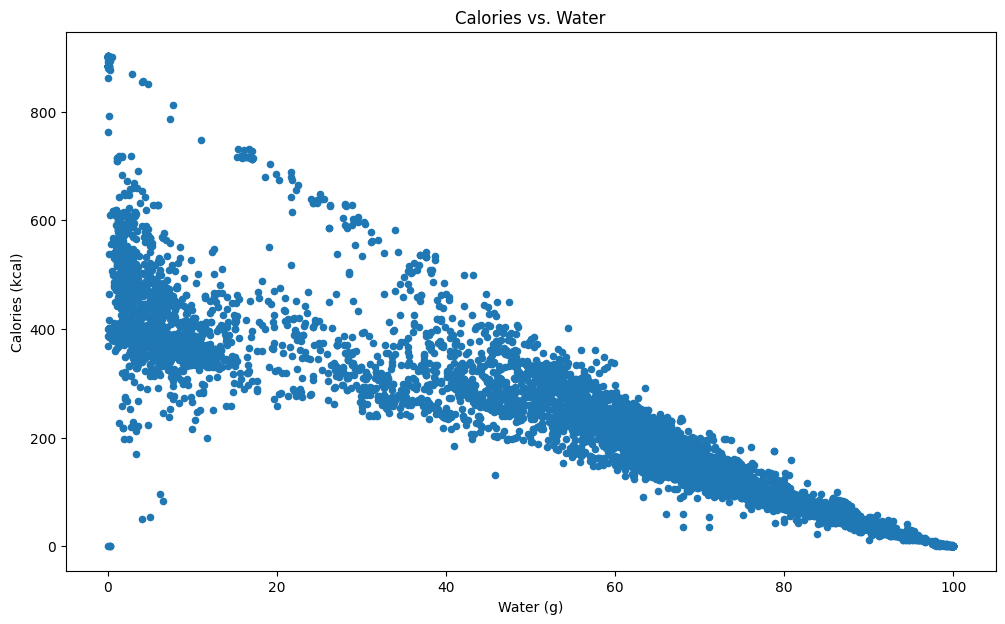

In [9]:
df_food.plot(kind='scatter',x='Water',y='Calories',figsize=(12,7))
plt.xlabel('Water (g)')
plt.ylabel('Calories (kcal)')
plt.title('Calories vs. Water')
plt.show()

### 3. What are the possible disadvantages of a no-carb diet? What potential health issues might arise from consuming too much protein?


Let's start by taking a look at the average nutritional content of zero-carb foods and compare it to foods with carbs.

#### Foods with no carbs

In [10]:
#Foods with no carbs
no_carb = df_food[df_food['Carbohydrate']==0]
avg_nc = no_carb.mean()
avg_nc = avg_nc.to_frame()
avg_nc.reset_index(inplace=True)
avg_nc.rename(columns={'index':'Property',0:'Amount'},inplace=True)
avg_nc

,Property,Amount
0,Calories,233.555012
1,Protein,22.289935
2,Carbohydrate,0.000000
3,Total fat,15.582214
4,Cholesterol,93.452760
5,Fiber,0.000000
6,Water,61.081712
7,Alcohol,0.105613
8,Vitamin C,0.669411


#### Foods with carbs

In [11]:
#Foods with carbs
carbs = df_food[df_food['Carbohydrate']!=0]
avg_c = carbs.mean()
avg_c = avg_c.to_frame()
avg_c.reset_index(inplace=True)
avg_c.rename(columns={'index':'Property',0:'Amount'},inplace=True)
avg_c

,Property,Amount
0,Calories,215.210256
1,Protein,8.008884
2,Carbohydrate,26.968587
3,Total fat,8.836752
4,Cholesterol,23.565517
5,Fiber,2.530681
6,Water,54.124863
7,Alcohol,0.136021
8,Vitamin C,11.384191


Next, we'll plot these values on a bar chart. Since Vitamin C and Cholesterol are measured in mg, we'll put those values on their own charts. This makes it easier to see the comparison in values.

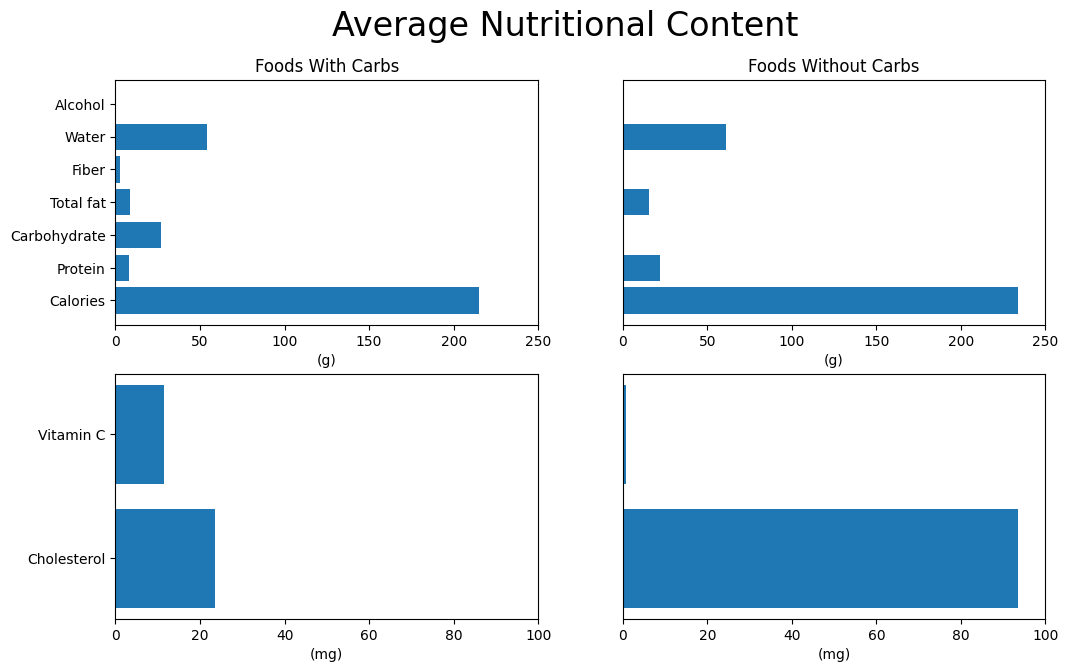

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12,7))

df = avg_c.drop([4,8])
ax[0,0].barh(df['Property'],df['Amount'])
ax[0,0].set_title('Foods With Carbs')
ax[0,0].set_xlabel('(g)')
ax[0,0].set_xlim(xmax=250)

df = avg_c.drop([0,1,2,3,5,6,7])
ax[1,0].barh(df['Property'],df['Amount'])
ax[1,0].set_xlabel('(mg)')
ax[1,0].set_xlim(xmax=100)

df = avg_nc.drop([4,8])
ax[0,1].barh(df['Property'],df['Amount'])
ax[0,1].set_title('Foods Without Carbs')
ax[0,1].set_xlabel('(g)')
ax[0,1].set_xlim(xmax=250)
ax[0,1].set_yticks([])

df = avg_nc.drop([0,1,2,3,5,6,7])
ax[1,1].barh(df['Property'],df['Amount'])
ax[1,1].set_xlabel('(mg)')
ax[1,1].set_xlim(xmax=100)
ax[1,1].set_yticks([])

fig.suptitle('Average Nutritional Content',fontsize=24)
#fig.legend(labels,loc='upper left')
fig.show()

#### Zero-Carb Diet
Here we can clearly see that foods without carbs do have less calories, however there are some potential drawbacks to this diet. Foods without carbs also have a higher amount of fats and cholesterol while also having no Vitamin C. A high fat diet can lead to cardiovascular disease. Not consuming Vitamin C can also lead to complications such as feeling tired and weak, aching legs and arms, swollen and bleeding gums, and anemia.

Next we'll take a look at a high protein diet with a similar approach.

The df_food dataframe is first split by foods with no protein and foods with protein.

#### Foods with no protein

In [13]:
#Foods with no protein
no_protein = df_food[df_food['Protein']==0]
avg_np = no_protein.mean()
avg_np = avg_np.to_frame()
avg_np.reset_index(inplace=True)
avg_np.rename(columns={'index':'Property',0:'Amount'},inplace=True)
avg_np

,Property,Amount
0,Calories,370.789790
1,Protein,0.000000
2,Carbohydrate,18.601081
3,Total fat,32.955345
4,Cholesterol,14.609610
5,Fiber,0.073574
6,Water,45.735976
7,Alcohol,1.090991
8,Vitamin C,11.045946


#### Foods with protein

In [14]:
#Foods with protein
protein = df_food[df_food['Protein']!=0]
avg_p = protein.mean()
avg_p = avg_p.to_frame()
avg_p.reset_index(inplace=True)
avg_p.rename(columns={'index':'Property',0:'Amount'},inplace=True)
avg_p

,Property,Amount
0,Calories,213.523005
1,Protein,12.459265
2,Carbohydrate,19.613029
3,Total fat,9.693361
4,Cholesterol,43.994638
5,Fiber,1.915080
6,Water,56.493126
7,Alcohol,0.084678
8,Vitamin C,8.328485


Next, we'll plot these values on a bar chart. Again, Vitamin C and Cholesterol are plotted separately.

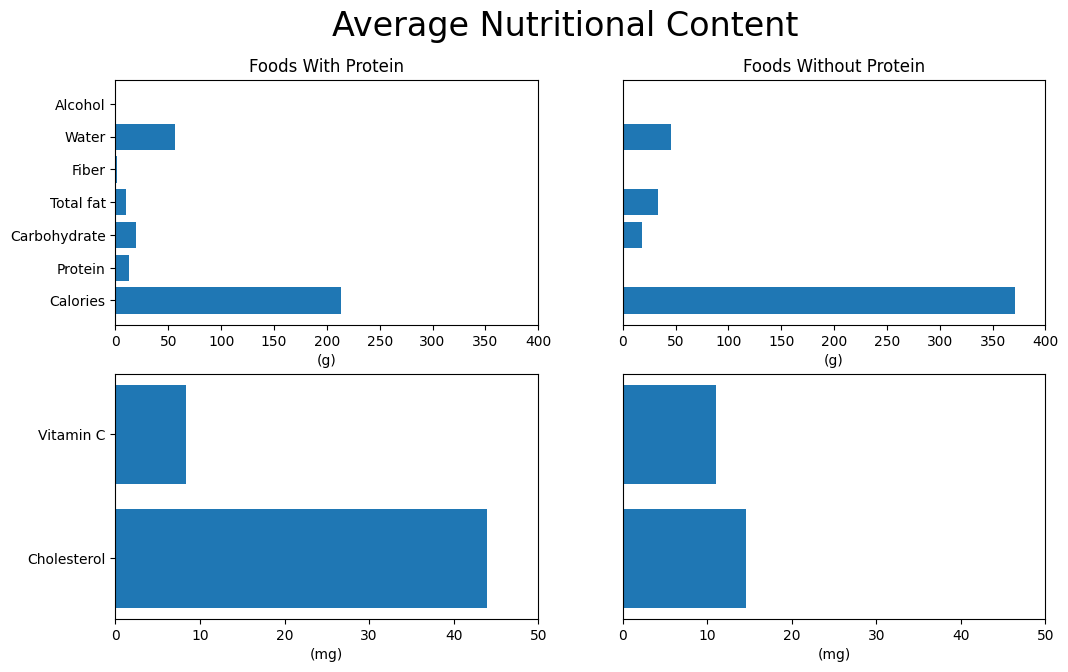

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12,7))

df = avg_p.drop([4,8])
ax[0,0].barh(df['Property'],df['Amount'])
ax[0,0].set_title('Foods With Protein')
ax[0,0].set_xlabel('(g)')
ax[0,0].set_xlim(xmax=400)

df = avg_p.drop([0,1,2,3,5,6,7])
ax[1,0].barh(df['Property'],df['Amount'])
ax[1,0].set_xlabel('(mg)')
ax[1,0].set_xlim(xmax=50)

df = avg_np.drop([4,8])
ax[0,1].barh(df['Property'],df['Amount'])
ax[0,1].set_title('Foods Without Protein')
ax[0,1].set_xlabel('(g)')
ax[0,1].set_xlim(xmax=400)
ax[0,1].set_yticks([])

df = avg_np.drop([0,1,2,3,5,6,7])
ax[1,1].barh(df['Property'],df['Amount'])
ax[1,1].set_xlabel('(mg)')
ax[1,1].set_xlim(xmax=50)
ax[1,1].set_yticks([])

fig.suptitle('Average Nutritional Content',fontsize=24)
fig.show()

It is interesting to see here that foods with protein have less calories, less fat, and more cholesterol than foods without protein. Otherwise, there are not many major difference between foods with and without protein. However, people aiming to consume a high protein diet will likely gravitate towards meats as a high protein source. Let's take a look at the top 5 protein containing foods.

In [16]:
avg_p = protein[['Category','Protein']].groupby(by='Category').mean()
avg_p.sort_values('Protein',inplace=True,ascending=False)
avg_p.head()

,Protein
Category,
Beef Products,24.399046
Poultry Products,23.206475
"Lamb, Veal, and Game Products",23.111379
Pork Products,22.139077
Finfish and Shellfish Products,20.353258


#### Average nutritional content of the top 5 protein sources

In [17]:
meat = protein.groupby(by='Category').mean()
meat.sort_values('Protein',inplace=True,ascending=False)
meat = meat.head()
meat = meat.apply(np.mean,axis=0)
meat = meat.to_frame()
meat.reset_index(inplace=True)
meat.rename(columns={'index':'Property',0:'Amount'},inplace=True)
meat

,Property,Amount
0,Calories,193.812663
1,Protein,22.641847
2,Carbohydrate,0.565007
3,Total fat,10.742311
4,Cholesterol,102.783843
5,Fiber,0.006703
6,Water,64.957964
7,Alcohol,0.000000
8,Vitamin C,1.033036


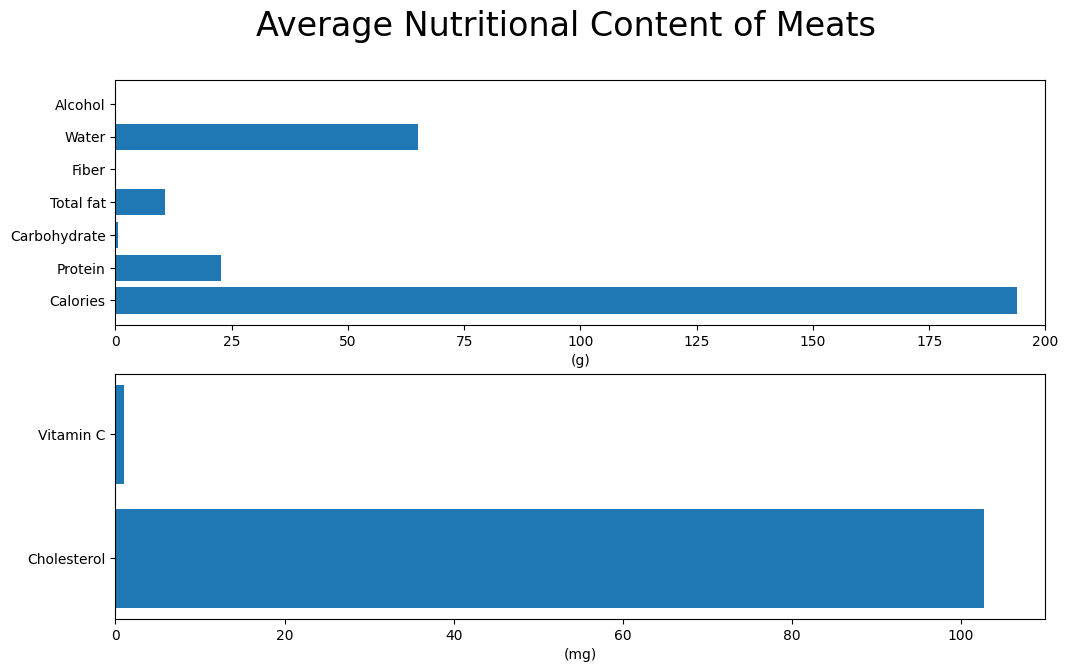

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(12,7))

df = meat.drop([4,8])
ax[0].barh(df['Property'],df['Amount'])
ax[0].set_xlabel('(g)')
ax[0].set_xlim(xmax=200)

df = meat.drop([0,1,2,3,5,6,7])
ax[1].barh(df['Property'],df['Amount'])
ax[1].set_xlabel('(mg)')
ax[1].set_xlim(xmax=110)

fig.suptitle('Average Nutritional Content of Meats',fontsize=24)
fig.show()

#### Very High Protein Diet
Now the picture is becoming more clear. From the bar chart we can see that meat products, while still maintaining a relatively low calorie count, are higher in cholesterol and fat and have little to no Vitamin C or Fiber. Here we are presented with the same issues as the zero-carb diet. High cholesterol intake is linked to cardiovascular disease and low Vitamin C intake can result in scurvy. In addition, a low fiber intake is assocated with constipation, irritable bowel syndrome (IBS), diverticulitis, heart disease and some cancers.

### 4. Since a gram of fat offers approximately 9 kilocalories and both protein and carbohydrates provide 4 kilocalories per gram, I intend to create a linear model to see if the data supports these values.

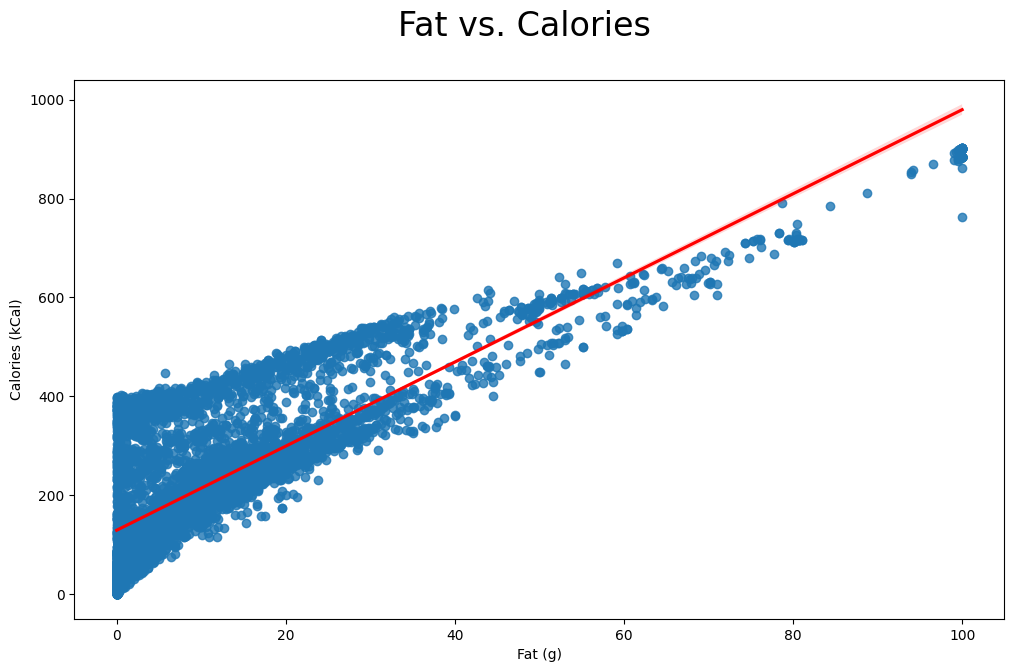

In [19]:
import seaborn as sns
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=(12, 7))

lr_fat = LinearRegression()
x = df_food[['Total fat']]
y = df_food[['Calories']]
lr_fat.fit(x,y)

sns.regplot(data=df_food,x=x,y=y,line_kws=dict(color="r"))
ax.set_xlabel('Fat (g)')
ax.set_ylabel('Calories (kCal)')
fig.suptitle('Fat vs. Calories', fontsize=24)
fig.show()

In [20]:
print('kCal/g of Fat:',round(lr_fat.coef_[0][0],2))

kCal/g of Fat: 8.5


kCal/g of Fat: 8.5

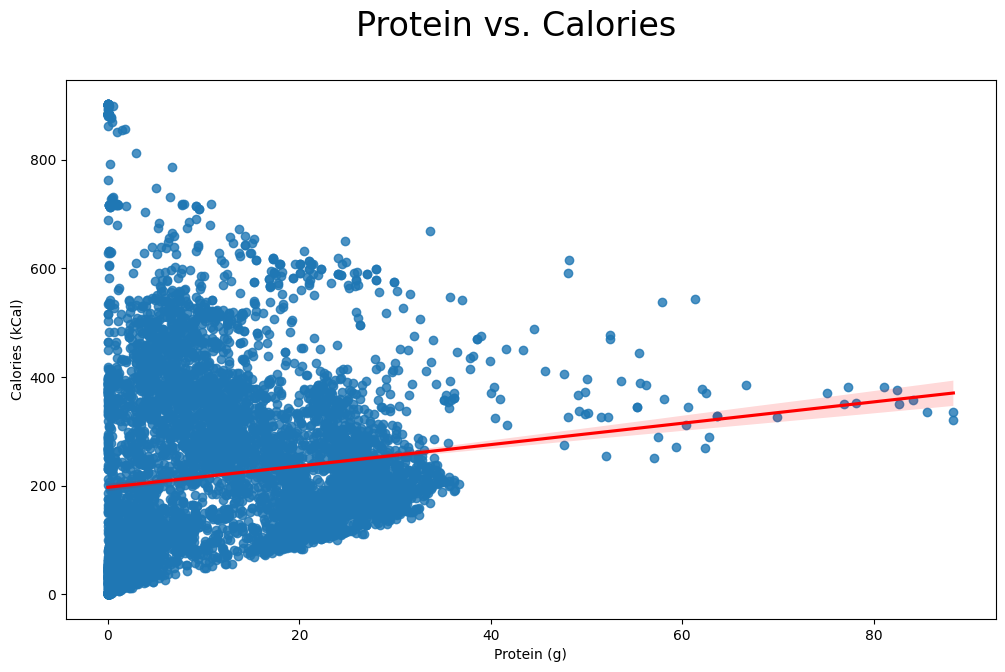

In [21]:
fig, ax = plt.subplots(figsize=(12, 7))

lr_protein = LinearRegression()
x = df_food[['Protein']]
y = df_food[['Calories']]
lr_protein.fit(x,y)

sns.regplot(data=df_food,x=x,y=y,line_kws=dict(color="r"))
ax.set_xlabel('Protein (g)')
ax.set_ylabel('Calories (kCal)')
fig.suptitle('Protein vs. Calories', fontsize=24)
fig.show()

In [22]:
print('kCal/g of Protein:',round(lr_protein.coef_[0][0],2))

kCal/g of Protein: 1.97


kCal/g of Protein: 1.97

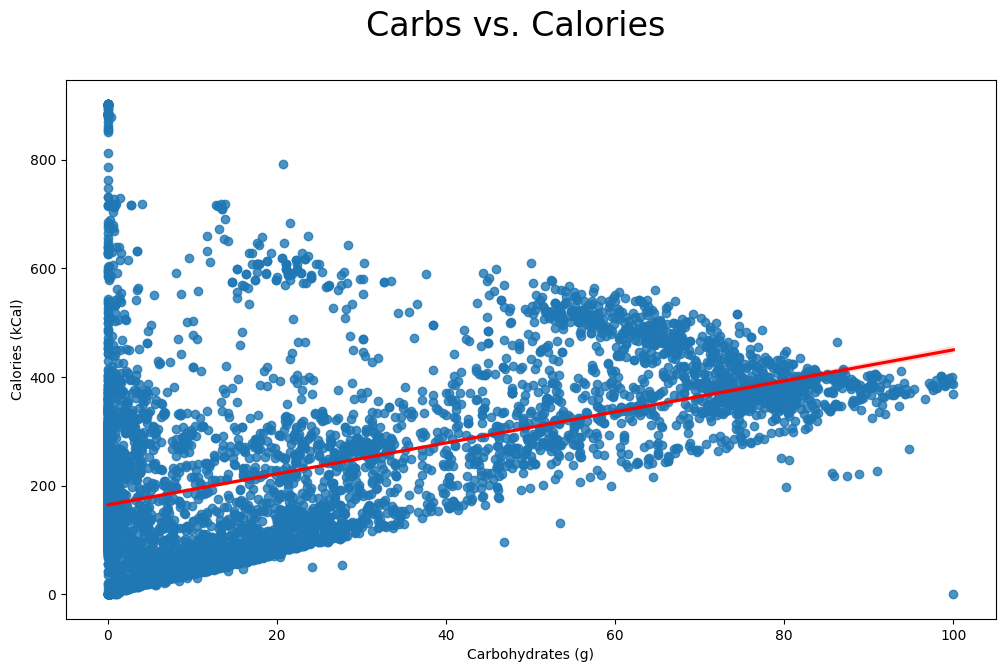

In [23]:
fig, ax = plt.subplots(figsize=(12, 7))

lr_carbs = LinearRegression()
x = df_food[['Carbohydrate']]
y = df_food[['Calories']]
lr_carbs.fit(x,y)

sns.regplot(data=df_food,x=x,y=y,line_kws=dict(color="r"))
ax.set_xlabel('Carbohydrates (g)')
ax.set_ylabel('Calories (kCal)')
fig.suptitle('Carbs vs. Calories', fontsize=24)
fig.show()

In [24]:
print('kCal/g of Carbs:',round(lr_carbs.coef_[0][0],2))

kCal/g of Carbs: 2.85


kCal/g of Carbs: 2.85

### 5. Analyze the errors of your linear model to see what could be the hidden sources of calories in food.

According to the Cleveland Clinic website, a gram of fat has around 9 kilocalories, and a gram of protein and a gram of carbohydrate contain 4 kilocalories each. We can see quite a bit of variation from this using the data from the USDA. Our data shows that Carbohydrates have 2.85 kCal/g, Protein has 1.97 kCal/g, and Fat has 8.5 kCal/g. Let's start by taking a look at the correlation between the nutritional properties of all foods.

In [25]:
cor = df_food.corr().round(3)
cor

,Calories,Protein,Carbohydrate,Total fat,Cholesterol,Fiber,Water,Alcohol,Vitamin C
Calories,1.000,0.126,0.435,0.826,0.026,0.188,-0.895,-0.019,-0.039
Protein,0.126,1.000,-0.309,0.056,0.281,-0.079,-0.131,-0.084,-0.075
Carbohydrate,0.435,-0.309,1.000,-0.075,-0.215,0.441,-0.734,-0.037,0.071
Total fat,0.826,0.056,-0.075,1.000,0.085,-0.015,-0.509,-0.049,-0.057
Cholesterol,0.026,0.281,-0.215,0.085,1.000,-0.141,0.041,-0.026,-0.030
Fiber,0.188,-0.079,0.441,-0.015,-0.141,1.000,-0.366,-0.034,0.057
Water,-0.895,-0.131,-0.734,-0.509,0.041,-0.366,1.000,0.039,-0.007
Alcohol,-0.019,-0.084,-0.037,-0.049,-0.026,-0.034,0.039,1.000,-0.009
Vitamin C,-0.039,-0.075,0.071,-0.057,-0.030,0.057,-0.007,-0.009,1.000


In [26]:
print('Correlation between Total Fat and Calories:',cor['Calories'].loc['Total fat'])
print('Regression Coefficient for Fat vs. Calories:',round(lr_fat.coef_[0][0],3),'\n')

print('Correlation between Carbohydrates and Calories:',cor['Calories'].loc['Carbohydrate'])
print('Regression Coefficient for Carbs vs. Calories:',round(lr_carbs.coef_[0][0],3),'\n')

print('Correlation between Protein and Calories:',cor['Calories'].loc['Protein'])
print('Regression Coefficient for Protein vs. Calories:',round(lr_protein.coef_[0][0],3))

Correlation between Total Fat and Calories: 0.826
Regression Coefficient for Fat vs. Calories: 8.504 

Correlation between Carbohydrates and Calories: 0.435
Regression Coefficient for Carbs vs. Calories: 2.855 

Correlation between Protein and Calories: 0.126
Regression Coefficient for Protein vs. Calories: 1.966


Correlation between Total Fat and Calories: 0.826\
Regression Coefficient for Fat vs. Calories: 8.504

Correlation between Carbohydrates and Calories: 0.435\
Regression Coefficient for Carbs vs. Calories: 2.855

Correlation between Protein and Calories: 0.126\
Regression Coefficient for Protein vs. Calories: 1.966

It's interesting to note that the further we get away from Cleveland Clinic's numbers, the correlation of Calories to that nutritional value also decreases. Since the values from the USDA data is lower than the expected values, I also find it intersting to note that the correlation of calories and water content presents the strongest negative correlation at -0.895. Let's run a linear regression model on Water vs. Calories.

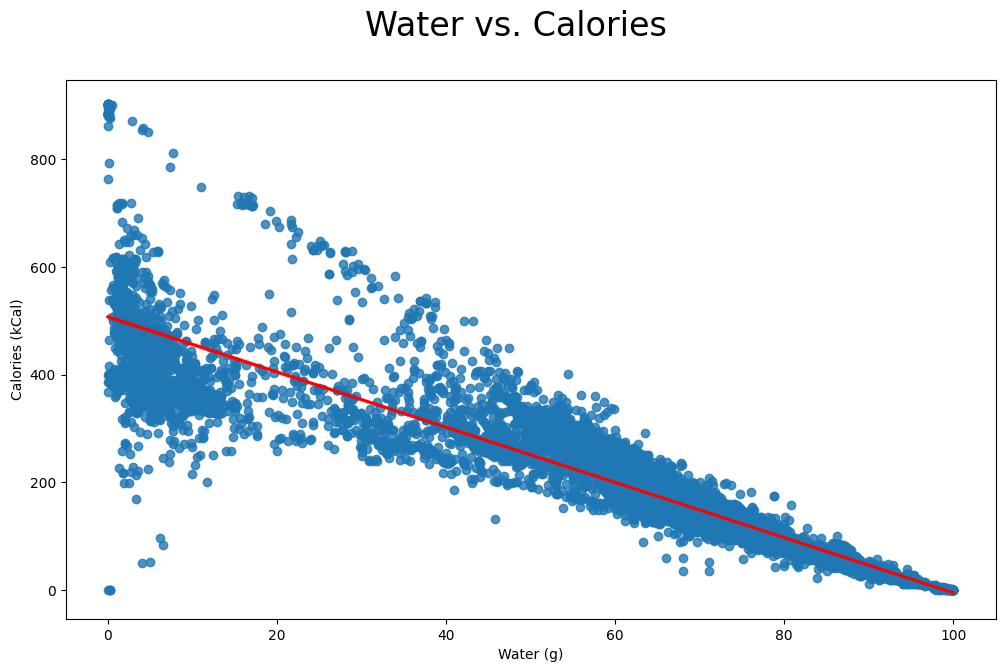

In [27]:
fig, ax = plt.subplots(figsize=(12, 7))

lr_water = LinearRegression()
x = df_food[['Water']]
y = df_food[['Calories']]
lr_water.fit(x,y)

sns.regplot(data=df_food,x=x,y=y,line_kws=dict(color="r"))
ax.set_xlabel('Water (g)')
ax.set_ylabel('Calories (kCal)')
fig.suptitle('Water vs. Calories', fontsize=24)
fig.show()

In [28]:
print('Correlation between Water and Calories:',cor['Calories'].loc['Water'])
print('Regression Coefficient for Water vs. Calories:',round(lr_water.coef_[0][0],3))

Correlation between Water and Calories: -0.895
Regression Coefficient for Water vs. Calories: -5.124


This seems to imply that foods with more water have fewer calories. Perhaps we should take a look at the distribution of the food categories. If the categories of foods are disproportionate, it could result in errors in our linear model.

In [29]:
counts = df_food['Category'].value_counts().to_frame()
counts.reset_index(inplace=True)
counts.rename(columns={'index':'Category','Category':'Count'},inplace=True)
counts

,Category,Count
0,Beef Products,954
1,Vegetables and Vegetable Products,814
2,Baked Products,517
3,"Lamb, Veal, and Game Products",464
4,Poultry Products,383
5,Beverages,366
6,Sweets,358
7,Fruits and Fruit Juices,355
8,Baby Foods,345
9,Pork Products,336


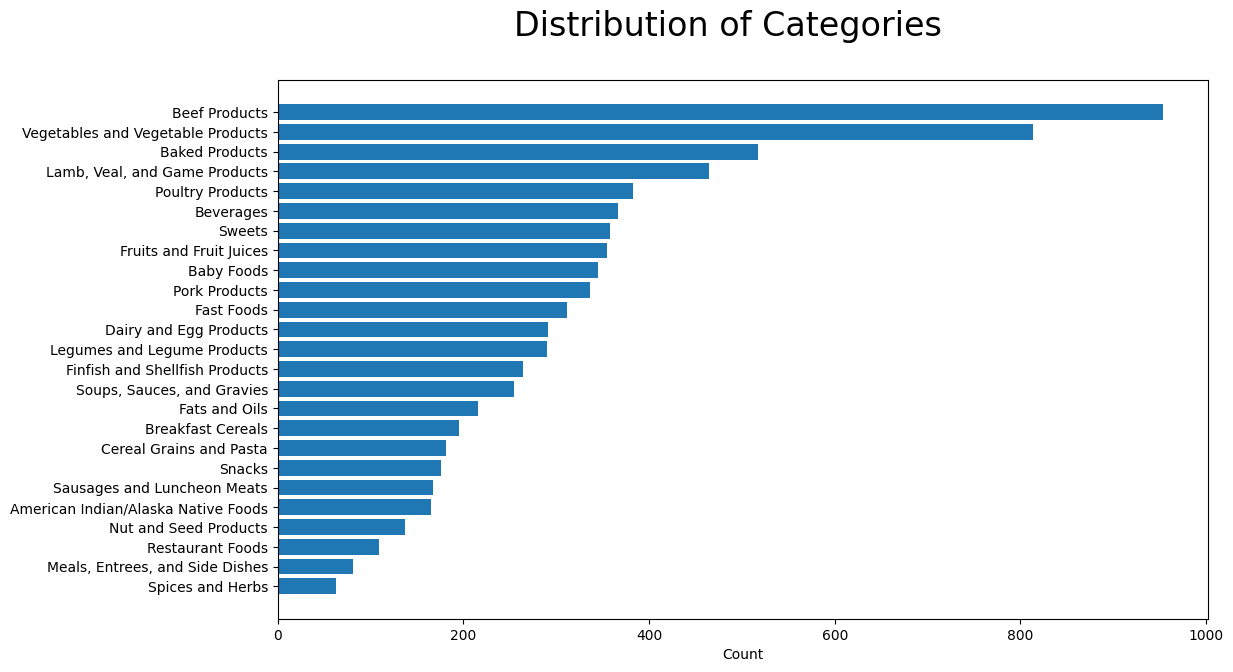

In [30]:
fig, ax = plt.subplots(figsize=(12,7))

counts.sort_values(by='Count',ascending=True,inplace=True)

ax.barh(counts['Category'],counts['Count'])
ax.set_xlabel('Count')

fig.suptitle('Distribution of Categories', fontsize=24)
fig.show()

In [31]:
beef_pct=round(df_food[df_food['Category']=='Beef Products'].shape[0]/df_food.shape[0],4)
veg_pct=round(df_food[df_food['Category']=='Vegetables and Vegetable Products'].shape[0]/df_food.shape[0],4)
print('Beef Products:','{:.2%}'.format(beef_pct))
print('Vegetables and Vegetable Products:','{:.2%}'.format(veg_pct))

Beef Products: 12.24%
Vegetables and Vegetable Products: 10.45%


Beef Products: 12.24%\
Vegetables and Vegetable Products: 10.45%

In [32]:
df_food.groupby('Category').mean().sort_values(by='Water',ascending=False)['Water'].head(3).to_frame()

,Water
Category,
Vegetables and Vegetable Products,82.425405
Fruits and Fruit Juices,76.371070
Beverages,76.178224


Here we can clearly see a disproportionate representation of categories in the data. With Vegetables having the highest water content and being the second highest category, we can predict that the disproportionatly high representation of vegetables is bringing down the number of calories per gram of carbohydrates in our linear model. We can explore this further by performing linear regression on the highest food category for Total Fat, Protein, and Carbohydrates.

#### Foods with the highest fat content

In [33]:
df_food.groupby('Category').mean().sort_values(by='Total fat',ascending=False)['Total fat'].head().to_frame()

,Total fat
Category,
Fats and Oils,67.186852
Nut and Seed Products,38.980219
Sausages and Luncheon Meats,19.816347
Snacks,17.061023
"Lamb, Veal, and Game Products",13.119138


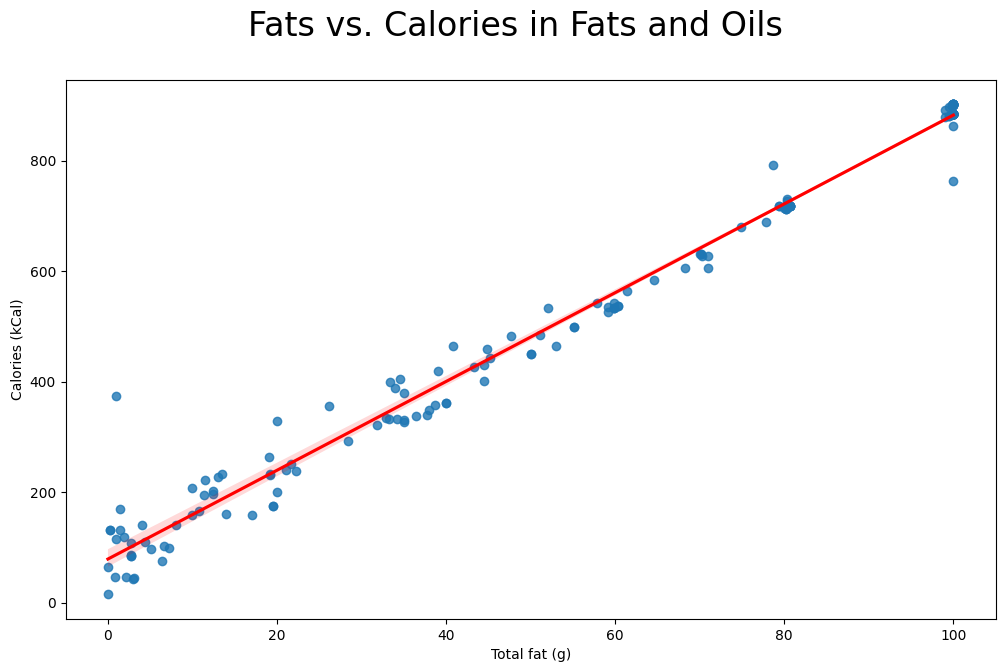

In [34]:
fig, ax = plt.subplots(figsize=(12, 7))

df = df_food[df_food['Category']=='Fats and Oils']

lr_fats = LinearRegression()
x = df[['Total fat']]
y = df[['Calories']]
lr_fats.fit(x,y)

sns.regplot(data=df_food,x=x,y=y,line_kws=dict(color="r"))
ax.set_xlabel('Total fat (g)')
ax.set_ylabel('Calories (kCal)')
fig.suptitle('Fats vs. Calories in Fats and Oils', fontsize=24)
fig.show()

In [35]:
print('kCal/g of Fat in Fats and Oils:',round(lr_fats.coef_[0][0],2))

kCal/g of Fat in Fats and Oils: 8.04


kCal/g of Fat in Fats and Oils: 8.04

#### Foods with the highest protein content

In [36]:
df_food.groupby('Category').mean().sort_values(by='Protein',ascending=False)['Protein'].head().to_frame()

,Protein
Category,
Beef Products,24.399046
Poultry Products,23.206475
"Lamb, Veal, and Game Products",23.111379
Pork Products,22.139077
Finfish and Shellfish Products,20.353258


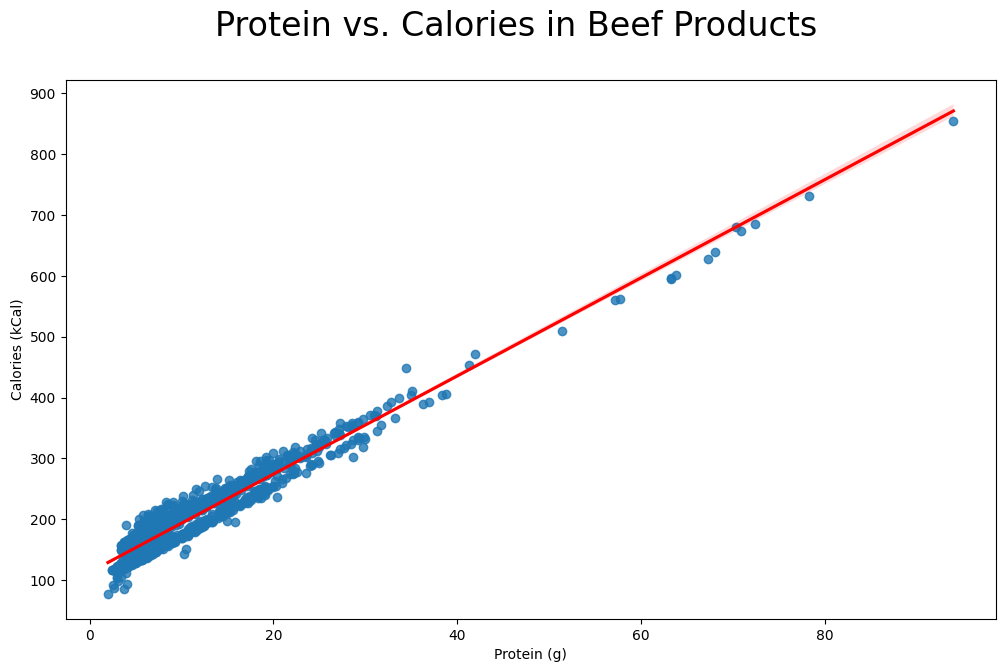

In [37]:
fig, ax = plt.subplots(figsize=(12, 7))

df = df_food[df_food['Category']=='Beef Products']

lr_protein = LinearRegression()
x = df[['Total fat']]
y = df[['Calories']]
lr_protein.fit(x,y)

sns.regplot(data=df_food,x=x,y=y,line_kws=dict(color="r"))
ax.set_xlabel('Protein (g)')
ax.set_ylabel('Calories (kCal)')
fig.suptitle('Protein vs. Calories in Beef Products', fontsize=24)
fig.show()

In [38]:
print('kCal/g of Protein in Beef Products:',round(lr_protein.coef_[0][0],2))

kCal/g of Protein in Beef Products: 8.06


kCal/g of Protein in Beef Products: 8.06

#### Foods with the highest carbohydrate content

In [39]:
df_food.groupby('Category').mean().sort_values(by='Carbohydrate',ascending=False)['Carbohydrate'].head().to_frame()

,Carbohydrate
Category,
Breakfast Cereals,67.790051
Snacks,64.492216
Cereal Grains and Pasta,58.473646
Sweets,56.176676
Baked Products,56.065803


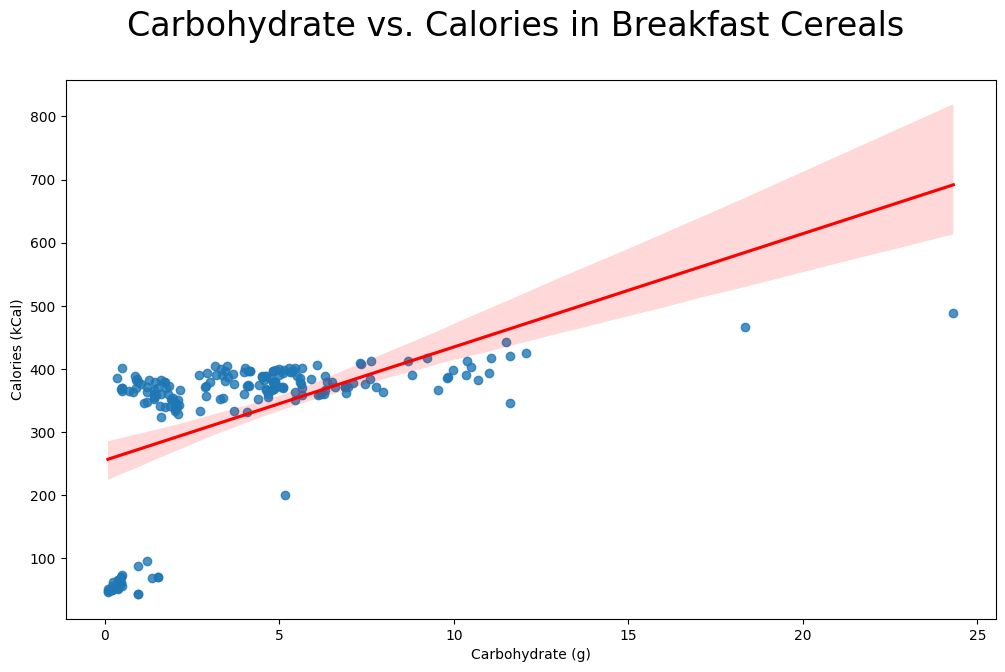

In [40]:
fig, ax = plt.subplots(figsize=(12, 7))

df = df_food[df_food['Category']=='Breakfast Cereals']

lr_carbs = LinearRegression()
x = df[['Total fat']]
y = df[['Calories']]
lr_carbs.fit(x,y)

sns.regplot(data=df_food,x=x,y=y,line_kws=dict(color="r"))
ax.set_xlabel('Carbohydrate (g)')
ax.set_ylabel('Calories (kCal)')
fig.suptitle('Carbohydrate vs. Calories in Breakfast Cereals', fontsize=24)
fig.show()

In [41]:
print('kCal/g of Protein in Breakfast Cereals:',round(lr_carbs.coef_[0][0],2))

kCal/g of Protein in Breakfast Cereals: 17.96


kCal/g of Protein in Breakfast Cereals: 17.96

In [42]:
print('Total Number of Fats and Oils:',df_food[df_food['Category']=='Fats and Oils'].shape[0])
print('Total Number of Beef Products:',df_food[df_food['Category']=='Beef Products'].shape[0])
print('Total Number of Breakfast Cereals:',df_food[df_food['Category']=='Breakfast Cereals'].shape[0])

Total Number of Fats and Oils: 216
Total Number of Beef Products: 954
Total Number of Breakfast Cereals: 195


Total Number of Fats and Oils: 216\
Total Number of Beef Products: 954\
Total Number of Breakfast Cereals: 195

## Conclusion

After conducting the linear regressions, the results have deviated even more from the predicted values. This discrepancy can be explained by the inadequate representation of certain food categories in the dataset. In the case of Beef Products versus Protein, we see results that are closest to the predicted value of 9 kCal/g, as Beef Products are the most prominently represented category in the data. Conversely, Breakfast Cereals, which have one of the lowest representations, show the greatest deviation from the predicted value.